In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret

In [2]:
import utils

In [3]:
pd.set_option('display.max_rows', 350)
pd.set_option('display.max_columns', 350)

In [4]:
seasonal_df = pd.read_csv('../data/seasonal_dataset.csv', sep='\t')
seasonal_phen_df = pd.read_csv('../data/seasonal_phen_dataset.csv', sep='\t')

In [5]:
target = 'Sitlav - Soybeans - Yield - KG/Ha'

# Exploratory data analysis
### Conduct exploratory data analysis to understand the data and its distribution. Include at least two visualizations that you find helpful.

A full EAD could be found on the preprocessing_eda notebook. 
In short:
* A lot of missing values
* Outliers in the target data
* Some columns contains strongly correlated value, usually from the same input vector (i.e temp_min, temp_max) 
* An interesting insight is that when grouping by plot id and calculating the std we get an avg of 400 - that could indicate about the changes done by the environment as we freeze the plot 

Showing the correlated columns:

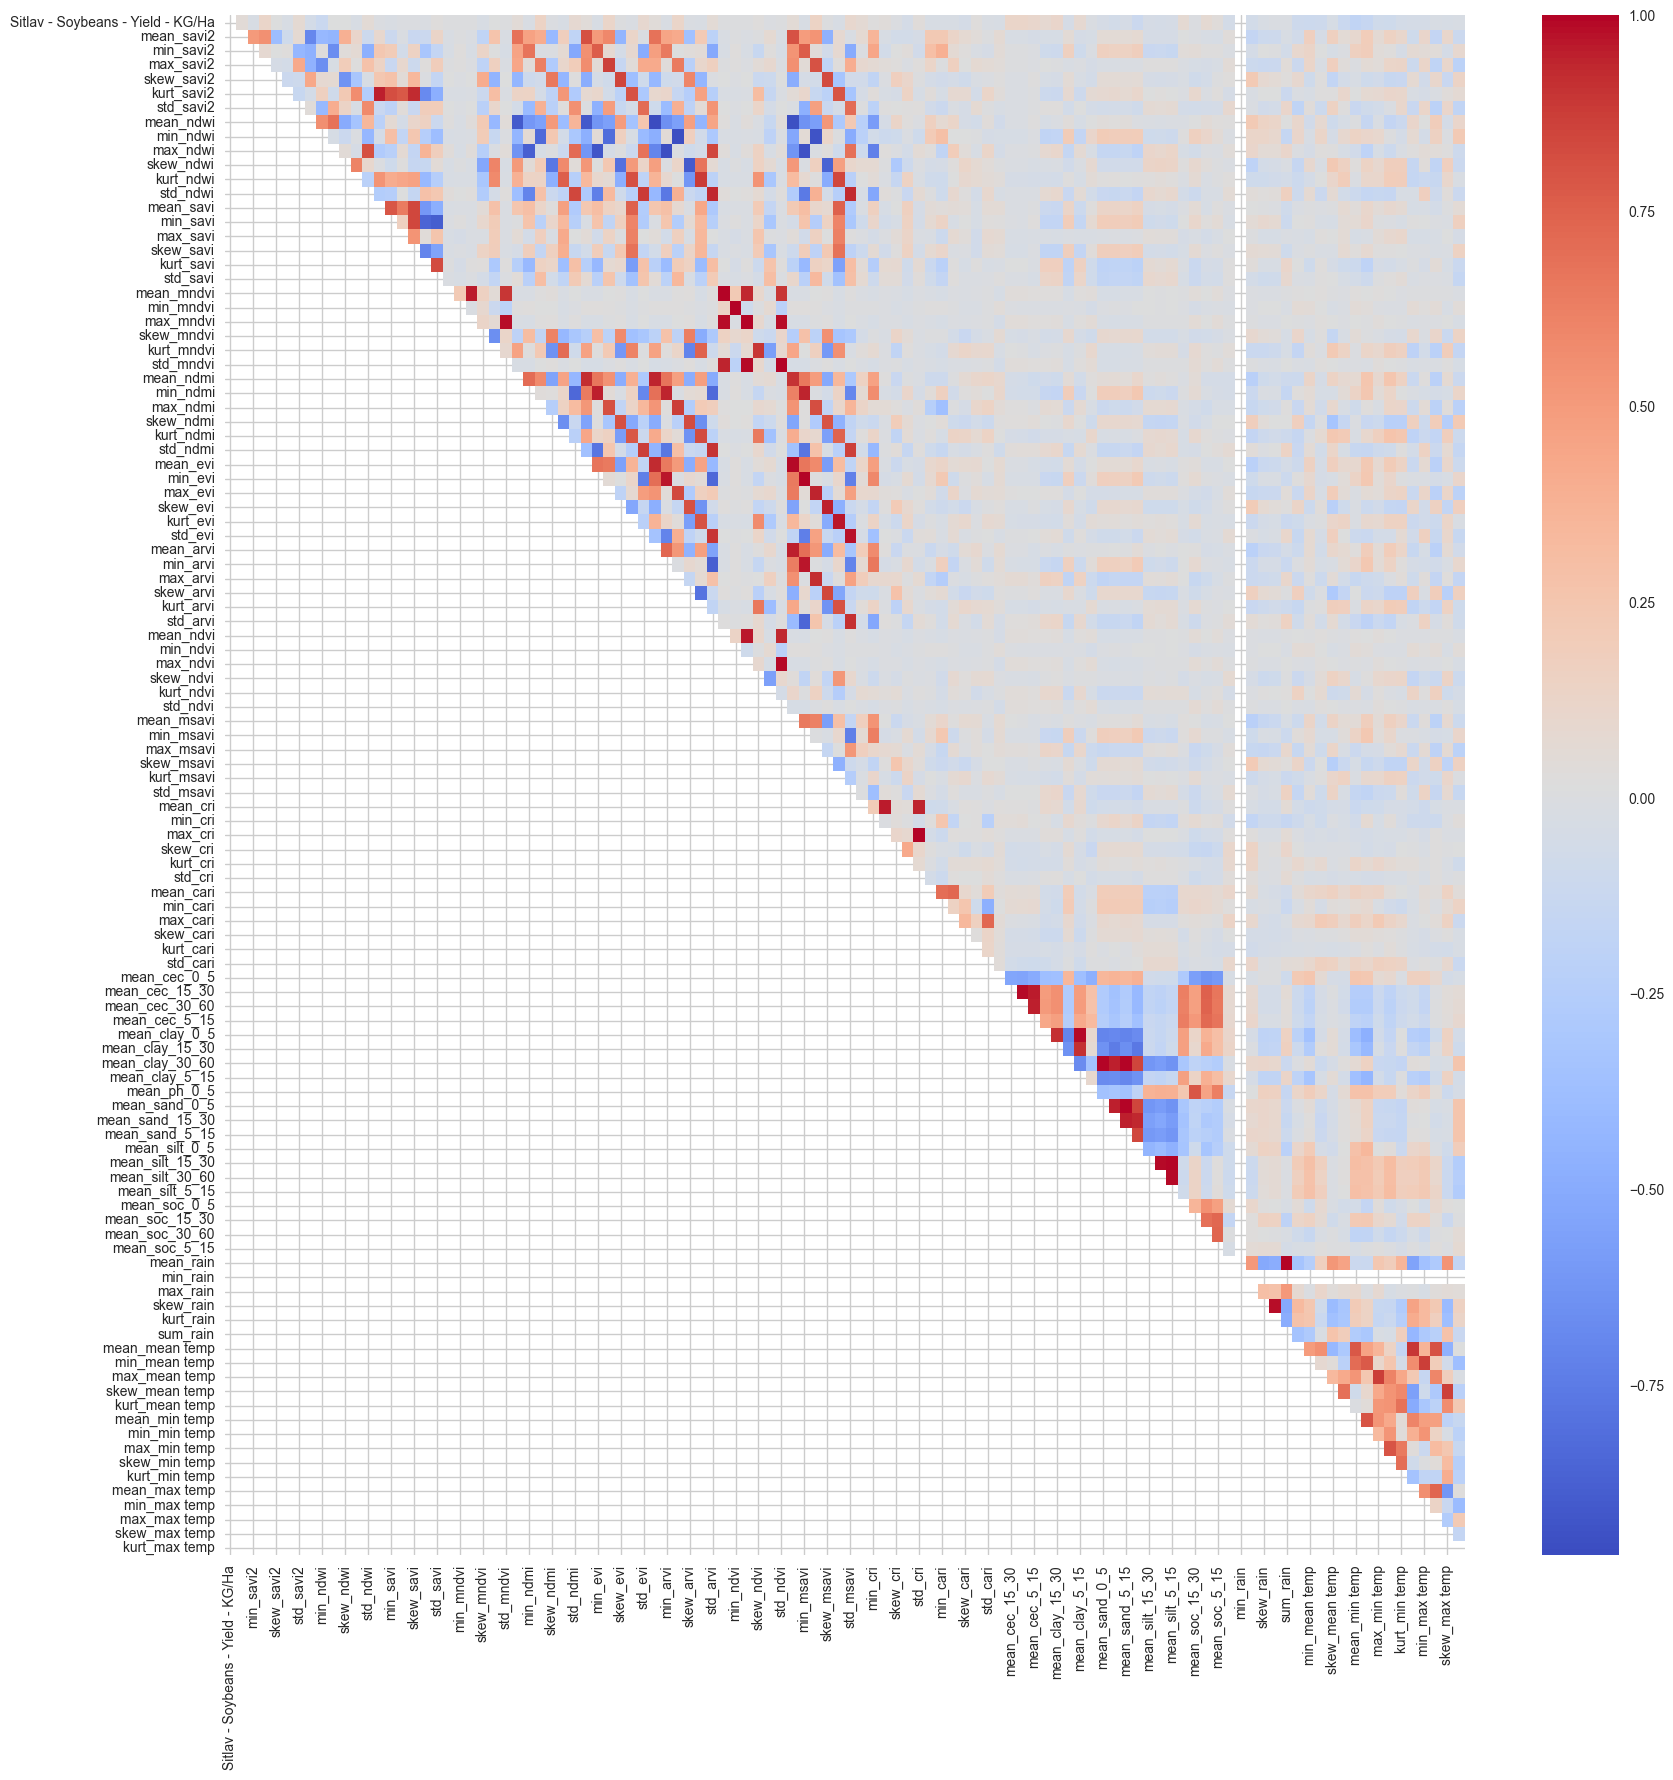

In [6]:
corr_mat = utils.plot_corr_marix(seasonal_df)

Showing the outlier cleaning process of the target column

<Axes: xlabel='Sitlav - Soybeans - Yield - KG/Ha', ylabel='Count'>

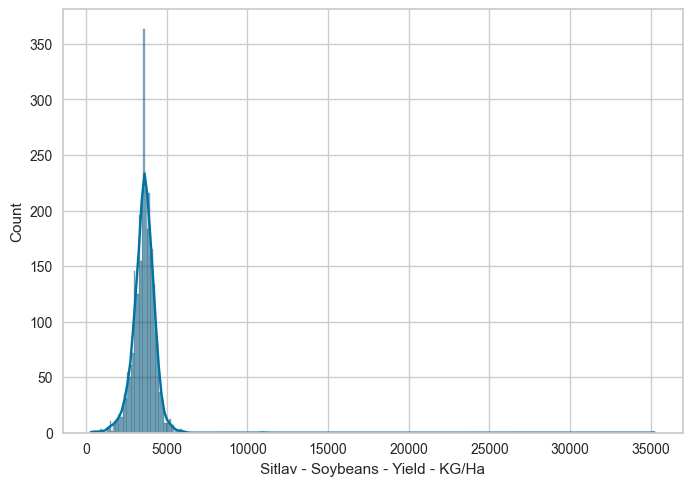

In [7]:
# Before: 
sns.histplot(seasonal_df.dropna(subset=['plot code'])['Sitlav - Soybeans - Yield - KG/Ha'], kde=True)

<Axes: xlabel='Sitlav - Soybeans - Yield - KG/Ha', ylabel='Count'>

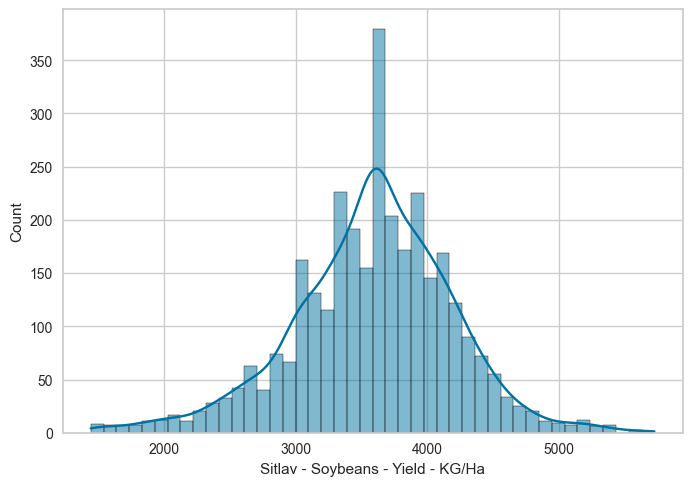

In [8]:
# After:
seasonal_df_target_clean = utils.clean_target_column(seasonal_df, target = target, mul_std=2.5)
sns.histplot(seasonal_df_target_clean.dropna(subset=['plot code'])['Sitlav - Soybeans - Yield - KG/Ha'], kde=True)


438.0606527328155

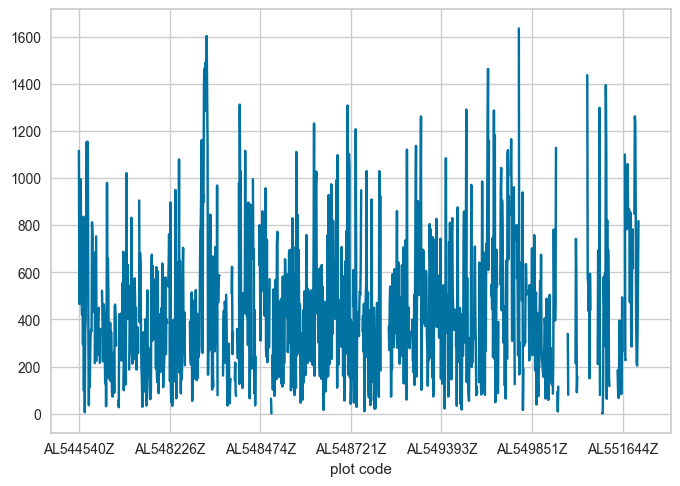

In [9]:
# Changes between seasons - ugly but we get the idea 
seasonal_df_target_clean.groupby('plot code')['Sitlav - Soybeans - Yield - KG/Ha'].std().plot()
seasonal_df_target_clean.groupby('plot code')['Sitlav - Soybeans - Yield - KG/Ha'].std().mean()

# Feature Engineering
We have already done some feature engineering so this could be skipped. But feel free to create any additional features that you think would be useful for predicting crop yield. Also think about what you could have done differently here.


The data we have was extracted from continues sampling.
We could:
1. Add the raw data itself in to a deep learning regressor as an extra channel 
2. Create counts of the number of stress events(anomalies) and how bad and long they where 
3. Detect data drifts and there lengths - we have phenological stages but they are "hard coded". It could be applied to all the data 
4. Figure out water deficit with ET 
5. Understand why there is so many missing values 
6. Create relative calculation from period to period (but try to avoid leakage :) )
7. Understand if there where external affects on the plot (extra shade, fertilizing, soil wash to change EC) 

# Model Selection
Build at least two models to predict crop yield. You may use any libraries or packages that you prefer.

So after the hole preprocessing we have a pipeline that looks like this, but as we saw there are a lot of correlated columns that we can clean by dropping them by a threshold... 
An other way is to use a feature selection model before. 
Lets start with the naive approach - i.e:
load data, clean, train several models and chose metric - we will use pycaret for this. I have another implementation based on lgbm but this is nice. 
The metric we would like to use is MAE, RMSE as they are measured on the same unit as the target 

In [10]:
def create_models(df, number_of_features = None):
    if number_of_features is None:
        number_of_features = df.shape[0]
    clean_df = (df
                        .pipe (utils.filter_nans,row_threshold = 0.5,col_threshold = 0.7)
                        .pipe (utils.clean_target_column, target = target, mul_std=2.5)
                        .pipe (utils.change_object_col_to_cat)
                        .round(3)
                        )
    return utils.creat_pycaret_models(clean_df,target=target)

The first table shown is the experiment details over view 

In [11]:
seasonal_exp, seasonal_exp_results = create_models(seasonal_df)

,Description,Value
0,Session id,125
1,Target,Sitlav - Soybeans - Yield - KG/Ha
2,Target type,Regression
3,Original data shape,"(2186, 101)"
4,Transformed data shape,"(2186, 72)"
5,Transformed train set shape,"(1530, 72)"
6,Transformed test set shape,"(656, 72)"
7,Numeric features,98
8,Categorical features,2
9,Rows with missing values,38.3%


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,305.4976,178388.2163,420.3513,0.4132,0.1315,0.0946,0.5710
catboost,CatBoost Regressor,311.8876,180152.6992,422.5000,0.4071,0.1321,0.0964,0.6570
rf,Random Forest Regressor,319.2592,190793.0754,435.3036,0.3704,0.1367,0.0993,0.5530
lightgbm,Light Gradient Boosting Machine,321.7420,194618.6923,439.4454,0.3575,0.1367,0.0992,0.5400
gbr,Gradient Boosting Regressor,333.5815,200864.5020,447.0083,0.3371,0.1399,0.1034,0.6410
xgboost,Extreme Gradient Boosting,339.2936,212316.7375,458.8756,0.3009,0.1434,0.1046,0.5760
ada,AdaBoost Regressor,380.4249,247188.3555,496.1003,0.1825,0.1542,0.1173,0.5590
en,Elastic Net,396.3809,277530.5285,525.6775,0.0855,0.1646,0.1243,0.5360
knn,K Neighbors Regressor,410.4248,287317.1609,533.9806,0.0541,0.1642,0.1258,0.5160
lr,Linear Regression,380.1763,283580.5679,524.4990,0.0513,0.1547,0.1175,1.2090


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [12]:
phen_exp, phen_exp_results =create_models(seasonal_phen_df)

,Description,Value
0,Session id,125
1,Target,Sitlav - Soybeans - Yield - KG/Ha
2,Target type,Regression
3,Original data shape,"(2067, 259)"
4,Transformed data shape,"(2067, 173)"
5,Transformed train set shape,"(1446, 173)"
6,Transformed test set shape,"(621, 173)"
7,Numeric features,256
8,Categorical features,2
9,Rows with missing values,66.7%


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,298.4044,169426.3209,410.9295,0.4594,0.1317,0.0938,0.6340
catboost,CatBoost Regressor,303.5759,173441.5752,415.8025,0.4462,0.1339,0.0955,0.6030
lightgbm,Light Gradient Boosting Machine,309.1452,178083.4529,421.2918,0.4313,0.1350,0.0968,0.5790
rf,Random Forest Regressor,311.5653,180882.4122,424.6268,0.4243,0.1367,0.0984,0.5650
gbr,Gradient Boosting Regressor,326.0965,195986.0627,442.4219,0.3750,0.1415,0.1027,0.6830
xgboost,Extreme Gradient Boosting,329.4637,200895.3812,447.7044,0.3591,0.1428,0.1029,0.6570
ada,AdaBoost Regressor,372.9794,236533.6896,486.0101,0.2460,0.1520,0.1151,0.6220
lasso,Lasso Regression,364.4968,254491.5806,499.6416,0.1965,0.1570,0.1138,0.6160
dummy,Dummy Regressor,424.0169,317592.9781,562.8858,-0.0084,0.1788,0.1358,0.5300
knn,K Neighbors Regressor,424.1105,318046.7406,563.1233,-0.0126,0.1769,0.1325,0.5310


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [13]:
def create_models_with_feature_selection(df, number_of_features = None):
    if number_of_features is None:
        number_of_features = df.shape[0]
    clean_df = (df
                    .pipe (utils.clean_target_column, target = target, mul_std=2.5)
                    .pipe (utils.feature_selection, target=target, number_of_features = number_of_features)
                )
    return utils.creat_pycaret_models(clean_df,target=target)

# Model Evaluation
Evaluate the performance of the models using appropriate metrics. Include visualizations to help communicate your results. This should be done for both datasets, then show what dataset works best (i.e. what is the better feature engineering)

As we can see the results are quite good as they are very close to each other and better the a average changed per plot-per season. 
It makes sense as both of the data sets contains all the data for the season and talking in kg 6 kg is the difference between them. 
Having said that with feature selection we can get to not-so-bad results (80kg/ha above expected) but we know the meaningful input features. 
We will show some feature importance figures and where the model preforms better 

Regular fine tunning could be done with 
tuned_dt = tune_model(dt, search_library = 'optuna')

In [14]:
et = phen_exp.create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,282.7583,157486.3492,396.8455,0.5218,0.1353,0.0923
1,291.6425,154938.8580,393.6227,0.4722,0.1265,0.0912
2,289.2863,147422.8607,383.9568,0.4790,0.1212,0.0886
3,318.9318,198035.8373,445.0122,0.4545,0.1439,0.1001
4,275.8802,159694.6848,399.6182,0.4026,0.1273,0.0870
5,321.6051,205335.1175,453.1392,0.3578,0.1526,0.1068
6,287.6843,147038.8083,383.4564,0.5695,0.1196,0.0904
7,311.2850,186147.6129,431.4483,0.4620,0.1425,0.1017
8,307.9420,161718.9870,402.1430,0.5033,0.1324,0.0978


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

We can see form the feature importance the the most important days for predicting the yield are the:
1. Early Reproductive Stages
2. Vegetative Growth

Also we can see how on the low 25% yield prediction the model has lower accuracy 

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

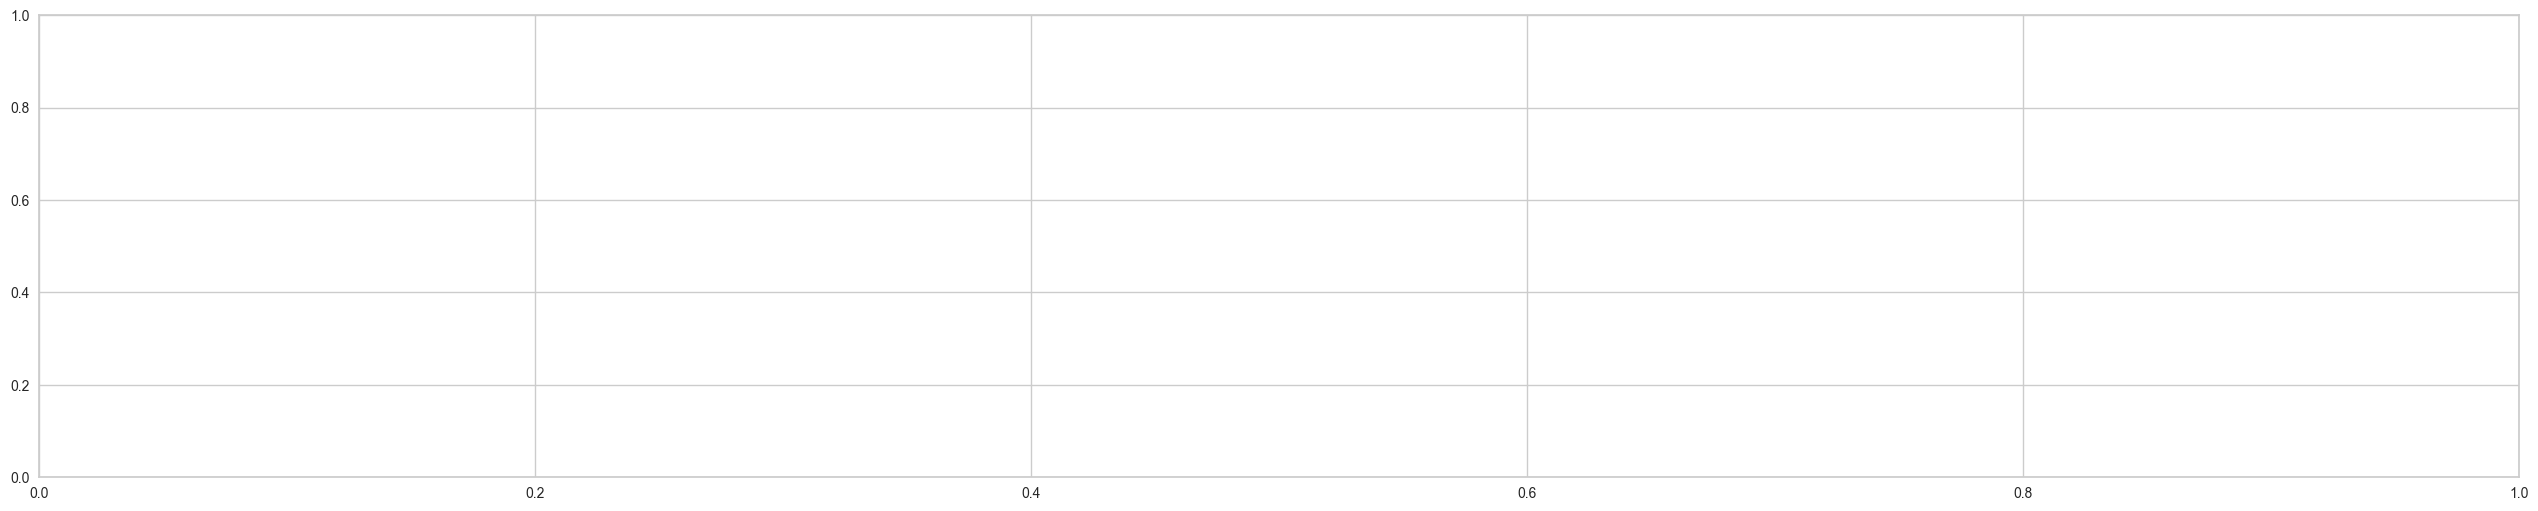

In [15]:
phen_exp.evaluate_model(et) 


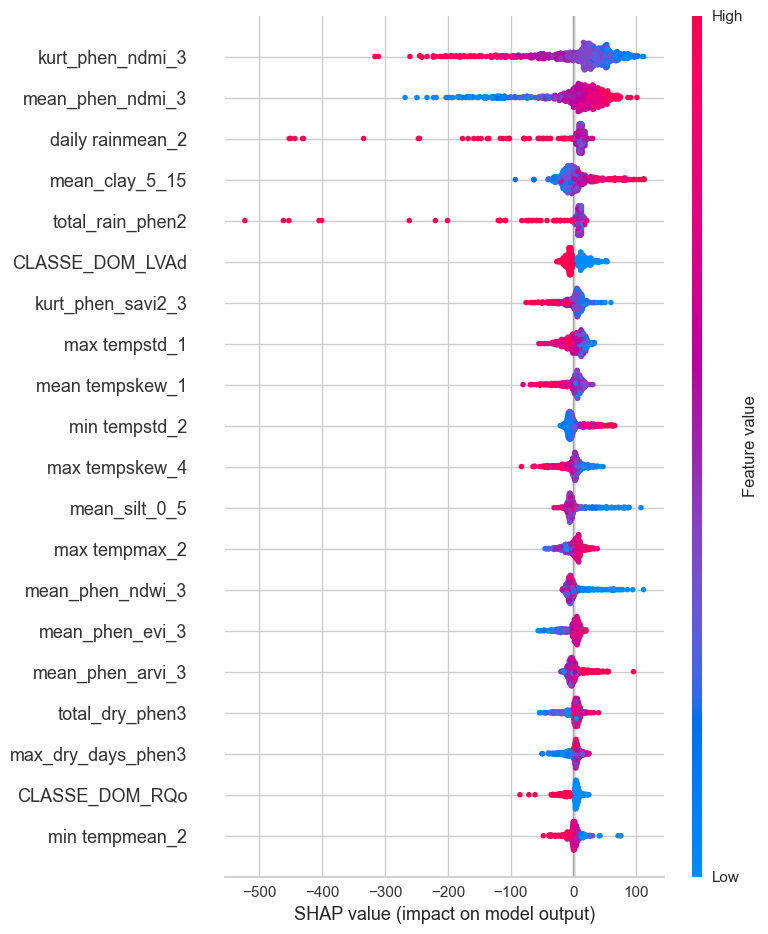

In [16]:
phen_exp.interpret_model(et)

# Model Tuning
Fine-tune the best performing model and provide a justification for your choices.

In [17]:
tuned_et = phen_exp.tune_model(et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,301.8944,186125.1182,431.4222,0.4348,0.1446,0.0989
1,316.4246,182956.2088,427.7338,0.3768,0.1372,0.1001
2,298.8267,168771.0260,410.8175,0.4035,0.1297,0.0931
3,337.0411,223547.4876,472.8081,0.3842,0.1517,0.1056
4,298.8408,163788.6174,404.7081,0.3873,0.1352,0.0953
5,328.5431,227230.0024,476.6865,0.2893,0.1592,0.1106
6,311.2930,166920.1604,408.5586,0.5113,0.1277,0.0988
7,328.3726,228029.6246,477.5245,0.3409,0.1572,0.1092
8,327.2495,187519.3650,433.0351,0.4241,0.1440,0.1061


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In practice it is better to retrain the model then to fine-tune as a model is more likely to over fit the data. Having said that I do believe that the hole pipeline (preprocessing, model selection) should be fine-tuned. I think that the choices to clean the data where reasonable there is a part in me that thinks we should check more option 

Ideally I'd like the param tunning to look more like below - I wasn't able to get it running but all the cleaning, rounding, removing multicollinearity, adding imputing and augmentations could be also a part of that process. In deep learning it is more important then in tree regressors.    

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import lightgbm as lgbm


preprocessor = Pipeline
(
    [
    ('filter_nans', FunctionTransformer(func=utils.filter_nans)),
    ('clean_target_colunm', FunctionTransformer(func=utils.clean_target_column)),
    ('feature_selection', FunctionTransformer(func=utils.feature_selection)),    
    ]
)
pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('clf', lgbm.LGBMRegressor())
    ]
)

param_grid = {
    'preprocessing__filter_nans__row_trashold': [0.5, 0.6, 0.7],
    'preprocessing__filter_nans__col_trashold': [0.7, 0.8, 0.9],
    'preprocessing__clean_target_column__mul_std': [2.5, 3 , 5],
    'preprocessing__create_bins_for_stratification__q': [5, 10, 15],
    'preprocessing__feature_selection__number_of_features': [5, 10, 500],
}

X = seasonal_df.copy().drop(columns=[target,'plot code'])
y = seasonal_df[target].copy()
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Business Insights
Provide recommendations on how the model can be used to optimize crop yield, including any limitations or potential biases that should be considered.


1. We should evaluate the model performance based on parts of the season and get more accurate as the season progress 
2. With a good model we know that when adjusting some of the input values we can get a prediction about the Yield impact  i.e if there we should irrigate to avoid more dry days
3. We could also understand how much money is worth taking action by knowing the abs(ideal Yield per kg - potential if no actions is taken) * price. 
If a farmer works with a sole client they might agree on a price before the season ends 
4. A good model could also suggest that some pro active actions should be taken i.e if it is to hot for the season so the avg temp gets high and covering/cooling the plot could help controlling the impact 

Limitations/Biases - 
1. Only data on Brazil
2. We don't know if all the trees are from the same specie
3. We have no idea about the fruit's quality only wight
4. We don't know anything about the season - it was a unique value per row 
5. We don't know the terrain that could affect the waters movement 
6. No irrigation data 
7. We don't know if the temp was measured inside the plot or outside 
8. We have no humidity, solar radiation data 
9. We don't know the age of the plot, some species has Intermittently behavior 
10. Some of the plots got very low/high Yields - that might indicate that there were problems in the growing process or crop insects or diseases
11. No data on fertilization  